In [1]:
import glob
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim

In [2]:
paths = glob.glob("/content/sample_data/project_dl/train" + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 100, replace=False) # choosing 100 images randomly
rand_idxs = np.random.permutation(100)
train_idxs = rand_idxs[:80] # choosing the first 80 as training set
val_idxs = rand_idxs[80:] # choosing last 20 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

80 20


In [3]:
test_paths = glob.glob("/content/sample_data/project_dl/test" + "/*.jpg")
print(len(test_paths))

16


In [4]:
random_paths = glob.glob("/content/sample_data/project_dl/random" + "/*.jpg")
print(len(random_paths))

45


# Create a DataSet

In [5]:
class ColornetDataset(Dataset):

  def __init__(self, paths, transform):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, idx):
    img = Image.open(self.paths[idx]).convert("RGB")
    img = self.transform(img)
    img = np.array(img)
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
    img_lab = transforms.ToTensor()(img_lab)
    L = img_lab[[0], ...] / 50. - 1. 
    ab = img_lab[[1, 2], ...] / 110. 

    return {'L': L, 'ab': ab}

  def __len__(self):
    return len(self.paths)


# Load Dataset

In [6]:
# Image transform for train and validation
train_transform = transforms.Compose([transforms.Resize([256,256]), transforms.RandomHorizontalFlip()])
val_transform = transforms.Compose([transforms.Resize([256,256])])

# Image transform for test
test_transform = transforms.Compose([transforms.Resize([256,256])])


#loading datasets
train_data = ColornetDataset(paths = train_paths, transform = train_transform)

val_data = ColornetDataset(paths = val_paths, transform = train_transform)

test_data = ColornetDataset(paths = test_paths, transform = test_transform)

random_data = ColornetDataset(paths = random_paths, transform = test_transform)
# print(len(test_data))

train_load = DataLoader(train_data, batch_size=32)
val_load = DataLoader(val_data, batch_size=32)
test_load = DataLoader(test_data, batch_size=8)
random_load = DataLoader(random_data, batch_size=8)


In [7]:
data = next(iter(train_load))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

torch.Size([32, 1, 256, 256]) torch.Size([32, 2, 256, 256])


In [8]:
data = next(iter(test_load))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

torch.Size([8, 1, 256, 256]) torch.Size([8, 2, 256, 256])


In [10]:
data = next(iter(random_load))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

torch.Size([8, 1, 256, 256]) torch.Size([8, 2, 256, 256])


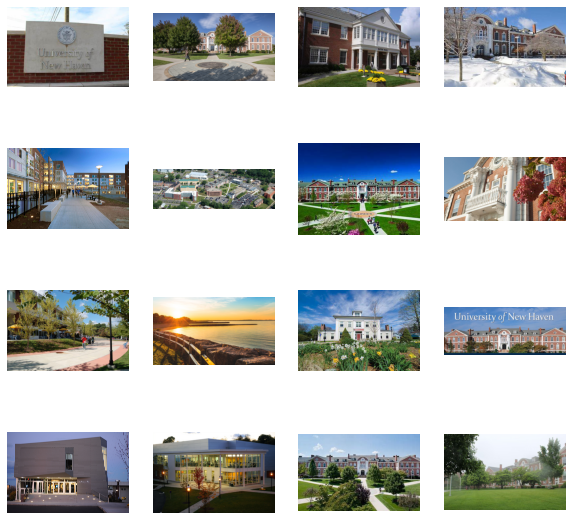

In [9]:
# viewing train images to see if they are loaded correctly

_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

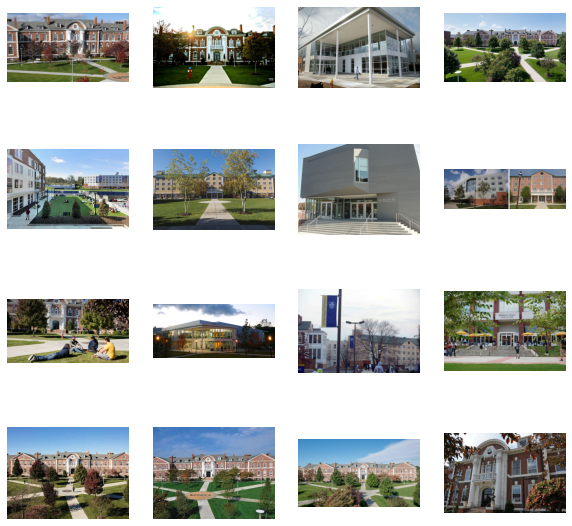

In [11]:
# viewing val images to see if they are loaded correctly

_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), val_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

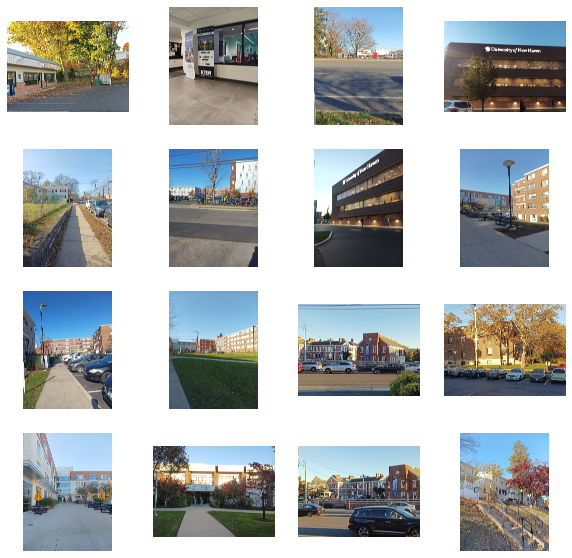

In [12]:
# viewing test images to see if they are loaded correctly

_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), test_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

# **Building A Model**

In [13]:
def upsample(c_in, c_out, dropout=False):
  result = nn.Sequential()
  result.add_module('con', nn.ConvTranspose2d(c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False))
  result.add_module('bat',nn.BatchNorm2d(c_out))
  if dropout:
    result.add_module('drop',nn.Dropout2d(0.5, inplace=True))
  result.add_module('relu',nn.ReLU(inplace=False))

  return result

In [14]:
def downsample(c_in, c_out, batchnorm=True):
  result = nn.Sequential()
  result.add_module('con', nn.Conv2d(c_in, c_out, kernel_size=4, stride=2, padding=1, bias=False))
  
  if batchnorm:
    result.add_module('batc',nn.BatchNorm2d(c_out))
  result.add_module('LRelu',nn.LeakyReLU(0.2, inplace=False))

  return result

### Building a Discriminator

In [15]:
class Discriminator(nn.Module):
  def __init__(self, n_channels=3, n_filters=64):
    super(Discriminator, self).__init__()

    main = nn.Sequential()
    main.add_module('conv1',nn.Conv2d(n_channels, n_filters, kernel_size=4, stride=2, padding=1, bias=False))
    
    main.add_module('ds1',downsample(n_filters, n_filters*2))
    
    n_filters = n_filters*2
    main.add_module('ds2',downsample(n_filters, n_filters*2))
    
    n_filters = n_filters*2
    main.add_module('LRelu',nn.LeakyReLU(0.2, inplace=False))
    main.add_module('conv2',nn.Conv2d(n_filters, n_filters*2, kernel_size=4, stride=1, padding=1, bias=False))
    main.add_module('batch',nn.BatchNorm2d(n_filters*2))
    
    n_filters = n_filters*2
    main.add_module('LRelu',nn.LeakyReLU(0.2, inplace=False))
    main.add_module('conv3', nn.Conv2d(n_filters, 1, kernel_size=4, stride=1, padding=1, bias=False))
    main.add_module('sig', nn.Sigmoid())

    self.main = main


  def forward(self, input):
    x = self.main(input)

    return x

### Building a Generator

In [16]:
class Generator(nn.Module):
  def __init__(self, input_nc=1, output_nc=2, n_filters=64):
    super(Generator, self).__init__()


    layer1 = nn.Conv2d(input_nc, n_filters, kernel_size=4, stride=2, padding=1, bias=False)
    layer2 = downsample(n_filters,n_filters*2)
    layer3 = downsample(n_filters*2, n_filters*4)
    layer4 = downsample(n_filters*4, n_filters*8)
    layer5 = downsample(n_filters*8, n_filters*8)
    layer6 = downsample(n_filters*8, n_filters*8)
    layer7 = downsample(n_filters*8, n_filters*8)
    layer8 = downsample(n_filters*8, n_filters*8)

    #decoder
    d_inc = n_filters*8
    dlayer8 = upsample(d_inc, n_filters*8, dropout=True)
    d_inc = n_filters*8*2
    dlayer7 = upsample(d_inc, n_filters*8, dropout=True)
    d_inc = n_filters*8*2
    dlayer6 = upsample(d_inc, n_filters*8, dropout=True)
    d_inc = n_filters*8*2
    dlayer5 = upsample(d_inc, n_filters*8)
    d_inc = n_filters*8*2
    dlayer4 = upsample(d_inc, n_filters*4)
    d_inc = n_filters*4*2
    dlayer3 = upsample(d_inc, n_filters*2)
    d_inc = n_filters*2*2
    dlayer2 = upsample(d_inc, n_filters)
    
    dlayer1 = nn.Sequential()
    d_inc = n_filters*2
    dlayer1.add_module('relu', nn.ReLU(inplace=False))
    dlayer1.add_module('t_conv', nn.ConvTranspose2d(d_inc, output_nc, kernel_size=4, stride=2, padding=1, bias=False))
    dlayer1.add_module('tanh', nn.Tanh())

    self.layer1 = layer1
    self.layer2 = layer2
    self.layer3 = layer3
    self.layer4 = layer4
    self.layer5 = layer5
    self.layer6 = layer6
    self.layer7 = layer7
    self.layer8 = layer8
    self.dlayer8 = dlayer8
    self.dlayer7 = dlayer7
    self.dlayer6 = dlayer6
    self.dlayer5 = dlayer5
    self.dlayer4 = dlayer4
    self.dlayer3 = dlayer3
    self.dlayer2 = dlayer2
    self.dlayer1 = dlayer1


  def forward(self, input):
    out1 = self.layer1(input)
    out2 = self.layer2(out1)
    out3 = self.layer3(out2)
    out4 = self.layer4(out3)
    out5 = self.layer5(out4)
    out6 = self.layer6(out5)
    out7 = self.layer7(out6)
    out8 = self.layer8(out7)
    dout8 = self.dlayer8(out8)
    dout8_out7 = torch.cat([dout8, out7], 1)
    dout7 = self.dlayer7(dout8_out7)
    dout7_out6 = torch.cat([dout7, out6], 1)
    dout6 = self.dlayer6(dout7_out6)
    dout6_out5 = torch.cat([dout6, out5], 1)
    dout5 = self.dlayer5(dout6_out5)
    dout5_out4 = torch.cat([dout5, out4], 1)
    dout4 = self.dlayer4(dout5_out4)
    dout4_out3 = torch.cat([dout4, out3], 1)
    dout3 = self.dlayer3(dout4_out3)
    dout3_out2 = torch.cat([dout3, out2], 1)
    dout2 = self.dlayer2(dout3_out2)
    dout2_out1 = torch.cat([dout2, out1], 1)
    dout1 = self.dlayer1(dout2_out1)
    return dout1



In [17]:
### Weight initialization

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

In [18]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(data, save=True):
    net_G.eval()
    with torch.no_grad():
        L = data['L'].to(device)
        ab = data['ab'].to(device)
        # forward
        fake_color = net_G(L)
    net_G.train()
    fake_color = fake_color.detach()
    real_color = ab
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        # ax.set_title('Grayscale Image')
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")        
        ax = plt.subplot(3, 5, i + 1 + 5)
        # ax.set_title('Colored Image')
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        # ax.set_title('Real Image')
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

# Initializing parameters

In [19]:
net_G=None
real_label=1.0
fake_label=0.0
lr_G=2e-4
lr_D=2e-4
beta1=0.5
beta2=0.999
lambda_L1=100.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
real_label = torch.tensor(real_label)
fake_label = torch.tensor(fake_label)

if net_G is None:
  net_G = Generator(input_nc=1, output_nc=2, n_filters=64).to(device)
  net_G.apply(weights_init)
else:
  net_G = net_G.to(device)
net_D = Discriminator(n_channels=3, n_filters=64).to(device)
net_D.apply(weights_init)
GANcriterion = nn.BCELoss().to(device) # nn.BCEWithLogitsLoss()
L1criterion = nn.L1Loss()
opt_G = optim.Adam(net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
opt_D = optim.Adam(net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

## Traning and evaluation

In [21]:
# Traning and evaluation
torch.autograd.set_detect_anomaly(True)
epochs = 100
display_every=10

data = next(iter(val_load)) # getting a batch for visualizing the model output after fixed intervals
loss_D_fake_col = []
loss_D_real_col = []
loss_D_col = []
loss_G_GAN_col = []
loss_G_L1_col = []
loss_G_col = []

print("Starting To Train...")

for e in range(epochs):
  i = 0                                 
  for data in train_load:
    L = data['L'].to(device)
    ab = data['ab'].to(device)
    # forward
    fake_color = net_G(L)
    net_D.train()
    for p in net_D.parameters():
      p.requires_grad = True
    opt_D.zero_grad()
    # backward discriminator
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = net_D(fake_image.detach())
    fk_labels = fake_label.expand_as(fake_preds).to(device)
    loss_D_fake = GANcriterion(fake_preds, fk_labels).to(device)

    real_image = torch.cat([L, ab], dim=1)
    real_preds = net_D(real_image)
    rl_labels = real_label.expand_as(real_preds).to(device)
    loss_D_real = GANcriterion(real_preds, rl_labels).to(device)
    loss_D = (loss_D_fake + loss_D_real) * 0.5
    loss_D.backward()

    opt_D.step()

    net_G.train()
    for p in net_D.parameters():
      p.requires_grad = False
    opt_G.zero_grad()
    # backward generator
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = net_D(fake_image)
    fk_labels = real_label.expand_as(fake_preds).to(device)
    loss_G_GAN = GANcriterion(fake_preds, fk_labels).to(device)
    loss_G_L1 = L1criterion(fake_color, ab) * lambda_L1
    loss_G = loss_G_GAN + loss_G_L1
    loss_G.backward()

    opt_G.step()
    
    # Collect losses for each iterations

    loss_D_fake_col.append(loss_D_fake.item())
    loss_D_real_col.append(loss_D_real.item())
    loss_D_col.append(loss_D.item()) 
    loss_G_GAN_col.append(loss_G_GAN.item())
    loss_G_L1_col.append(loss_G_L1.item())
    loss_G_col.append(loss_G.item())

    i += 1
    if i % display_every == 0:
      print(f"\nEpoch {e+1}/{epochs}")
      print(f"Iteration {i}/{len(train_load)}")

      print(f"loss_D_fake: {round(np.mean(loss_D_fake_col),4)}")
      print(f"loss_D_fake: {round(np.mean(loss_D_fake_col),4)}")
      print(f"loss_D_real: {round(np.mean(loss_D_real_col),4)}")
      print(f"loss_D: {round(np.mean(loss_D_col),4)}")
      print(f"loss_G_GAN: {round(np.mean(loss_G_GAN_col),4)}")
      print(f"loss_G_L1: {round(np.mean(loss_G_L1_col),4)}")
      print(f"loss_G: {round(np.mean(loss_G_col),4)}")

      visualize(data, save=False) # function displaying the model's outputs



Starting To Train...


# Loss versus training iteration



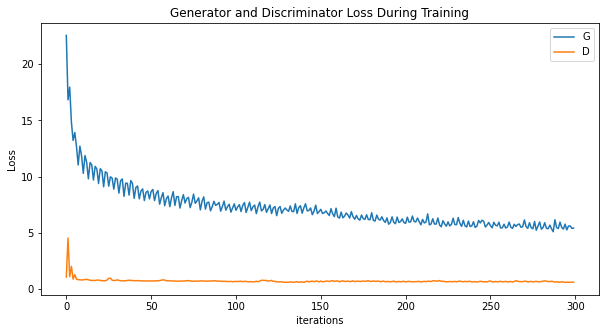

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_G_col,label="G")
plt.plot(loss_D_col,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


#Coloring Test Images

In [23]:
for data in test_load:
    net_G.eval()
    with torch.no_grad():
        L = data['L'].to(device)
        ab = data['ab'].to(device)
        fake_color = net_G(L)
        
    net_G.train()
    fake_color = fake_color.detach()
    real_color = ab
    real_imgs = lab_to_rgb(L, real_color)
    
    
    fake_test_imgs = lab_to_rgb(L, fake_color)
   

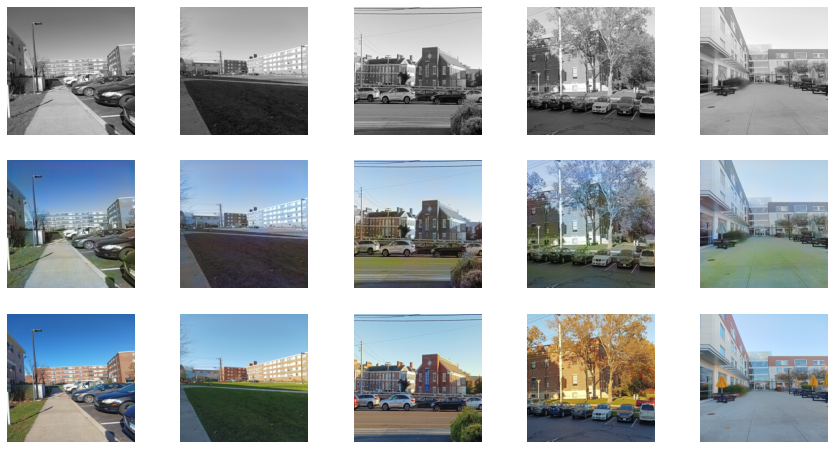

In [24]:
fig = plt.figure(figsize=(15, 8))
for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(L[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 5)
    ax.imshow(fake_test_imgs[i])
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 10)
    ax.imshow(real_imgs[i])
    ax.axis("off")
plt.show()

In [25]:
for data in random_load:
    net_G.eval()
    with torch.no_grad():
        L_r = data['L'].to(device)
        ab_r = data['ab'].to(device)
        fake_color = net_G(L_r)
        
    net_G.train()
    fake_color = fake_color.detach()
    real_color = ab_r
    real_imgs_r = lab_to_rgb(L_r, real_color)
    
    fake_test_imgs_r = lab_to_rgb(L_r, fake_color)

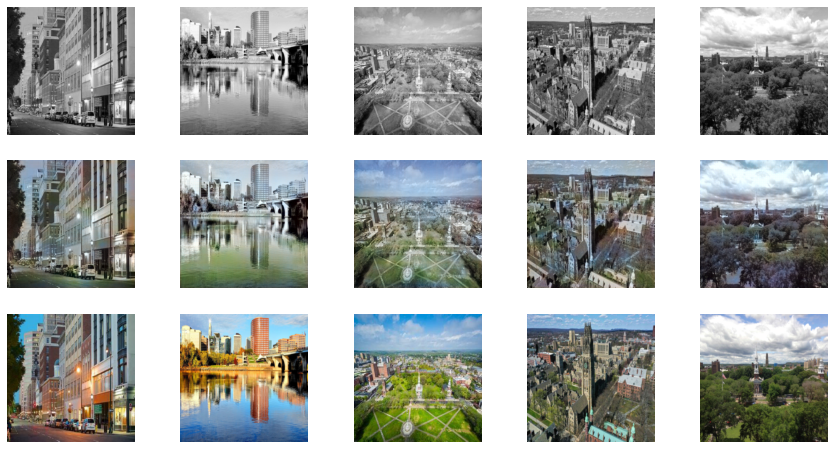

In [26]:
fig = plt.figure(figsize=(15, 8))
for i in range(5):
    ax = plt.subplot(3, 5, i + 1)
    ax.imshow(L_r[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 5)
    ax.imshow(fake_test_imgs_r[i])
    ax.axis("off")
    ax = plt.subplot(3, 5, i + 1 + 10)
    ax.imshow(real_imgs_r[i])
    ax.axis("off")
plt.show()